### Scraping

In [1]:
#import selenium
#from selenium import webdriver
import numpy as np
import pandas as pd
#from bs4 import BeautifulSoup
#import requests
import time
import re
import csv
    
###Scraper Omitted###

### Quick LDA visualization with sklearn

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, PCA
from sklearn.cluster import KMeans

df = pd.read_csv("nature.txt", delimiter = ',', encoding='latin1')

df['text'] = df['text'].apply(lambda x: re.sub(r"199", "", x))
vectorizer = CountVectorizer(stop_words="english", ngram_range=(2,2))

#Fit and transform the count vectorizer
X_counts = vectorizer.fit_transform(df['text'])

lda = LatentDirichletAllocation(n_topics=10, learning_method='batch')
lda.fit(X_counts)

def print_top_words(model, feature_names, n_top_words):
    print('\n--------------------------------\n')
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % (topic_idx+1))
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        print('\n--------------------------------\n')
        
print_top_words(lda, vectorizer.get_feature_names(),n_top_words = 15)


--------------------------------

Topic #1:
nature letter, et al, letter nature, file contains, contains supplementary, news views, es cells, stem cell, nature news, nature article, extended data, al nature, treg cells, work supported, 000 years

--------------------------------

Topic #2:
file contains, contains supplementary, et al, news views, extended data, supplementary table, stem cells, nature news, glp 1r, protein coupled, long term, authors contributed, supplementary tables, views nature, work supported

--------------------------------

Topic #3:
et al, file contains, contains supplementary, news views, nature news, extended data, breast cancer, views nature, stem cells, authors contributed, gene expression, work supported, contributed equally, equally work, editing levels

--------------------------------

Topic #4:
file contains, et al, nature letter, contains supplementary, letter nature, news views, work supported, science foundation, authors contributed, black hole, wro

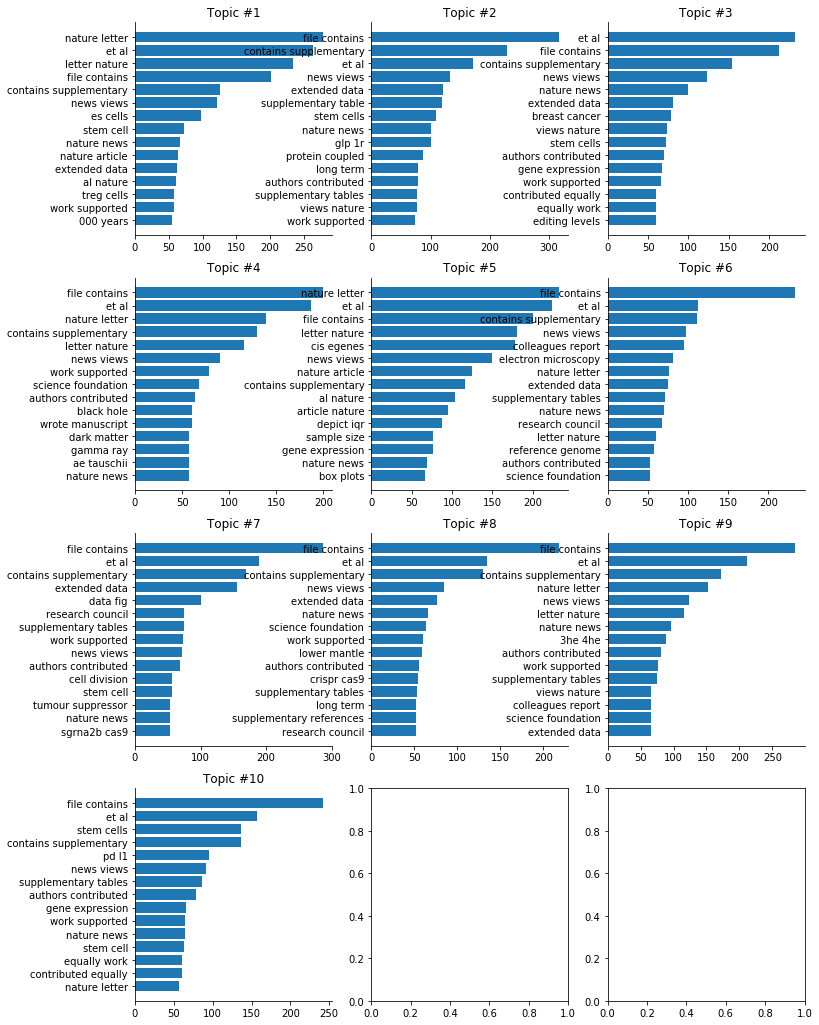

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_features(coef, feature_names, top_n=15, ax=None, title=None):
    """
    Parameters
    ----------
    coef            :     array-like, list of coefficients, unsorted
    
    feature_names   :     array-like, list of feature names indexed according to coefficients
    
    top_n           :     int, number of features to print
    
    ax              :     matplotlib axes object, axes to plot on
    
    title           :     string, title to be given to the plot
    
    
    Outputs
    -------
    Creates a bar plot on the specified axis of coefficients and their names.
    If not axis is supplied then a new plot is created.
    """
    
    #Initialize an axis if None is given
    if ax is None:
        return None
        ax = plt.gca()
    
    #Sort to coefficients and take the top_n
    inds = np.argsort(coef)
    high = inds[-top_n:]
    
    #Define a range for the plot
    myrange = range(len(high))
    
    #Plot the bar chart for features
    ax.barh(myrange, coef[high])
    ax.set_yticks(myrange)
    
    ax.set_yticklabels([feature_names[h] for h in high])
    ax.yaxis.labelpad=10
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    #If a title is given, give the plot a title
    if title:
        ax.set_title(title)

components = lda.components_
feature_names = vectorizer.get_feature_names()

fig, axes = plt.subplots(4,3, figsize=(12, 18))
for component,ax,i in zip(components, axes.flatten(), range(1,11)):
    plot_features(component, feature_names, ax=ax, title = 'Topic #%d' %i)

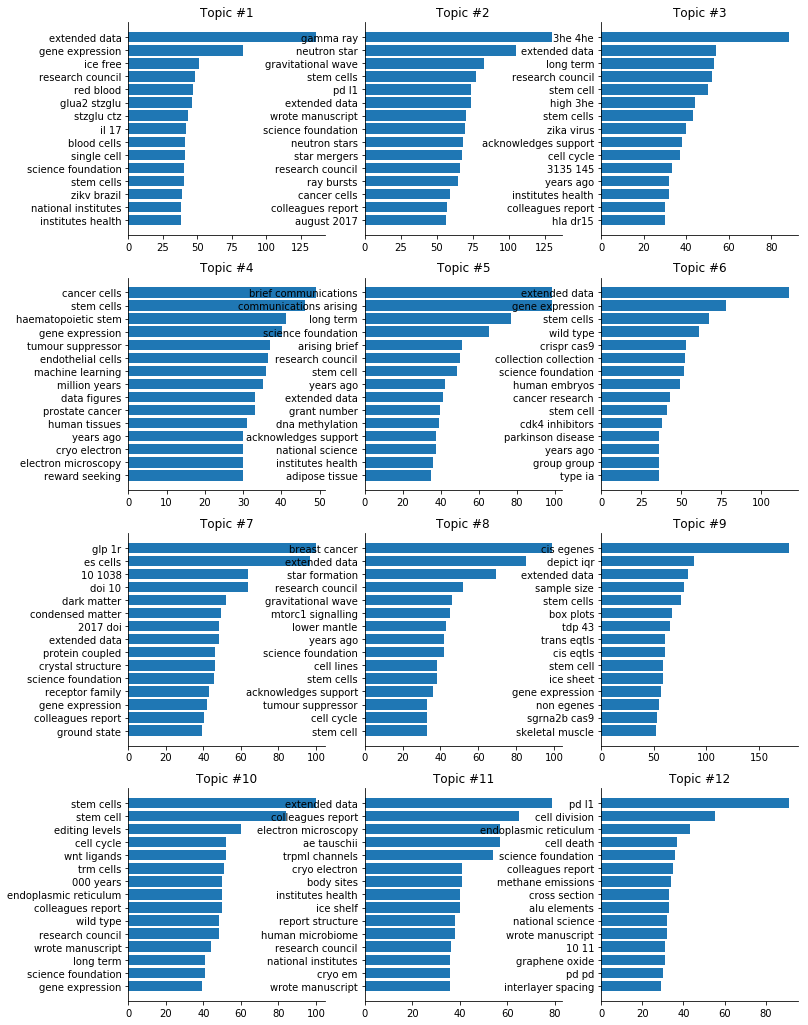

In [5]:
num_topics = 12
from sklearn.feature_extraction import stop_words

stopwords = list(stop_words.ENGLISH_STOP_WORDS)


black_list = ["file", "contains", "et", "al", "nature", 
 "letter", "supplementary", "news", "views", 
 "article", "letters", "articles", "table", 
 "tables", "figure", "work", "supported", 
 "author", "authors", "contributed", "fig", 
 "199", "200", "reference", "references"]

stopwords = set(stopwords + black_list)

vectorizer = CountVectorizer(stop_words=stopwords, ngram_range=(2,2))

#Fit and transform the count vectorizer
X_counts = vectorizer.fit_transform(df['text'])

lda = LatentDirichletAllocation(n_topics=num_topics, learning_method='batch')
lda.fit(X_counts)

components = lda.components_
feature_names = vectorizer.get_feature_names()

fig, axes = plt.subplots(4,3, figsize=(12, 18))
for component,ax,i in zip(components, axes.flatten(), range(1,num_topics + 1)):
    plot_features(component, feature_names, ax=ax, title = 'Topic #%d' %i)

### LDA and Visualization with Gensim

In [6]:
import PyPDF2
import csv

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from gensim import corpora
from gensim.models import LdaModel

import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline

import pyLDAvis.gensim

def bigram_preprocess(tokens, deacc=True, lowercase=True, errors='ignore',
    stemmer=None, stopwords=None):
    """
    Convert a document into a list of tokens.
    Split text into sentences and sentences into bigrams.
    the bigrams returned are the tokens
    """
    bigrams = []

    if len(tokens) >1:
        for i in range(0,len(tokens)-1):
            yield tokens[i] + '_' + tokens[i+1]

#nltk.download()

C:\ProgramData\Anaconda2\envs\py35\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [7]:
df = pd.read_csv('nature.txt', encoding='latin1')

documents = df['text']

black_list = ["file", "contains", "et", "al", "nature", 
 "letter", "supplementary", "news", "views", 
 "article", "letters", "articles", "table", 
 "tables", "figure", "work", "supported", 
 "author", "authors", "contributed", "fig", 
 "199", "200", "reference", "references"]


stop_words = set(list(stopwords.words('english')) + black_list)

texts = [word_tokenize(doc)  for doc in documents]
texts_lower = [[word.lower() for word in text] for text in texts]
unigrams = [[word for word in text if not word.isdigit() and word not in stop_words and len(word) > 1] for text in texts_lower]

bigrams = [[bigram for bigram in bigram_preprocess(text)] for text in unigrams]

dictionary_bigrams = corpora.Dictionary(bigrams, prune_at=20000000)
dictionary_bigrams.save_as_text('gensim_dict_bigrams.txt')

dictionary_unigrams = corpora.Dictionary(unigrams, prune_at=20000000)
dictionary_unigrams.save_as_text('gensim_dict_unigrams.txt')

In [9]:
corpus = [dictionary_bigrams.doc2bow(text) for text in bigrams]
lda = LdaModel(corpus, num_topics=10, id2word=dictionary_bigrams)

pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda, corpus, dictionary_bigrams)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
2      11.885151        1       1  0.030248 -0.007867
0      11.072315        1       2  0.003805  0.021849
3      10.950410        1       3 -0.012435 -0.008297
9      10.108669        1       4 -0.001856  0.009223
1      10.045935        1       5 -0.013670 -0.002411
8       9.894944        1       6 -0.000136  0.007329
4       9.862474        1       7 -0.006209 -0.023186
7       9.133948        1       8 -0.001581  0.001892
6       8.731901        1       9 -0.006646  0.007710
5       8.314254        1      10  0.008481 -0.006240, topic_info=       Category        Freq                                  Term       Total  \
term                                                                            
28597   Default   84.000000                communications_arising   84.000000   
245449  Default   85.000000                  brief_communications   85.000000   
168773  Default  260.000000                              per_cent  260.000000   
230257  Default   43.000000                         arising_brief   43.000000   
93068   Default  459.000000                            stem_cells  459.000000   
147513  Default   41.000000                             trm_cells   41.000000   
9276    Default    7.000000  epithelial-to-mesenchymal_transition    7.000000   
18286   Default   62.000000                        adipose_tissue   62.000000   
35625   Default  136.000000                         breast_cancer  136.000000   
110714  Default  110.000000                        climate_change  110.000000   
106151  Default  229.000000                             years_ago  229.000000   
162704  Default   27.000000                 quantum_teleportation   27.000000   
184704  Default  341.000000                     colleagues_report  341.000000   
102858  Default   98.000000                              es_cells   98.000000   
119955  Default   64.000000                            fatty_acid   64.000000   
232873  Default   13.000000             non-covalent_interactions   13.000000   
27602   Default    5.000000                metastasis_contributes    5.000000   
109402  Default  146.000000                         tumour_growth  146.000000   
243973  Default   88.000000                           black_holes   88.000000   
207679  Default    5.000000           contributes_chemoresistance    5.000000   
206908  Default    5.000000                   transition_required    5.000000   
109854  Default   46.000000                          solar_system   46.000000   
139092  Default  208.000000                             stem_cell  208.000000   
25360   Default  170.000000              cryo-electron_microscopy  170.000000   
5200    Default   95.000000                            black_hole   95.000000   
138679  Default    5.000000               chemoresistance_472476    5.000000   
178177  Default    5.000000                         required_lung    5.000000   
82306   Default   17.000000                     hypothalamic_stem   17.000000   
92969   Default    5.000000          r._epithelial-to-mesenchymal    5.000000   
151090  Default   28.000000                       surface_tension   28.000000   
...         ...         ...                                   ...         ...   
27424   Topic10   26.200266                     institutes_health  280.295897   
184704  Topic10   28.274011                     colleagues_report  341.741434   
108285  Topic10   30.432761                      research_council  407.804183   
76936   Topic10    9.541067                      particle_physics   52.852922   
142650  Topic10   23.715766                   national_institutes  268.947828   
5200    Topic10   13.100449                            black_hole   95.373548   
195000  Topic10    6.622049                  electronic_structure   28.983726   
164792  Topic10   21.587515                      national_science  27

In [10]:
corpus = [dictionary_unigrams.doc2bow(text) for text in unigrams]
lda = LdaModel(corpus, num_topics=10, id2word=dictionary_unigrams)

pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda, corpus, dictionary_unigrams)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
5      14.774829        1       1  0.004814 -0.012357
9      12.494094        1       2 -0.009593 -0.010652
8      12.060217        1       3  0.020005  0.006908
1      11.251967        1       4 -0.015326  0.009528
3       9.196453        1       5 -0.000486 -0.006498
0       8.746228        1       6 -0.008107 -0.005286
4       8.599056        1       7 -0.005498  0.016726
6       8.204206        1       8 -0.001068  0.001973
7       7.477785        1       9  0.004977 -0.003150
2       7.195164        1      10  0.010281  0.002807, topic_info=      Category         Freq         Term        Total  loglift  logprob
term                                                                   
27736  Default  5028.000000        cells  5028.000000  30.0000  30.0000
19259  Default  1258.000000      quantum  1258.000000  29.0000  29.0000
12493  Default  1256.000000         mice  1256.000000  28.0000  28.0000
8397   Default  4332.000000         data  4332.000000  27.0000  27.0000
11210  Default  3065.000000         cell  3065.000000  26.0000  26.0000
13238  Default  1233.000000  experiments  1233.000000  25.0000  25.0000
21191  Default  1394.000000      complex  1394.000000  24.0000  24.0000
25341  Default  2589.000000         show  2589.000000  23.0000  23.0000
28174  Default  1570.000000           a.  1570.000000  22.0000  22.0000
35287  Default  1914.000000           j.  1914.000000  21.0000  21.0000
19794  Default  2021.000000     analysis  2021.000000  20.0000  20.0000
17128  Default   952.000000      neurons   952.000000  19.0000  19.0000
6507   Default  2164.000000       cancer  2164.000000  18.0000  18.0000
46829  Default   916.000000         stem   916.000000  17.0000  17.0000
41747  Default  1408.000000          dna  1408.000000  16.0000  16.0000
33990  Default  1798.000000        using  1798.000000  15.0000  15.0000
43177  Default  1341.000000        could  1341.000000  14.0000  14.0000
35993  Default  1520.000000   foundation  1520.000000  13.0000  13.0000
42358  Default  1439.000000      protein  1439.000000  12.0000  12.0000
34898  Default  2059.000000           m.  2059.000000  11.0000  11.0000
47378  Default  1549.000000     national  1549.000000  10.0000  10.0000
10108  Default  1608.000000         used  1608.000000   9.0000   9.0000
48141  Default   529.000000      climate   529.000000   8.0000   8.0000
3239   Default   988.000000     activity   988.000000   7.0000   7.0000
3314   Default   530.000000         zikv   530.000000   6.0000   6.0000
7204   Default  2163.000000         also  2163.000000   5.0000   5.0000
23681  Default   605.000000        earth   605.000000   4.0000   4.0000
10289  Default  3042.000000     research  3042.000000   3.0000   3.0000
43963  Default  1764.000000        thank  1764.000000   2.0000   2.0000
2983   Default  1040.000000        mouse  1040.000000   1.0000   1.0000
...        ...          ...          ...          ...      ...      ...
33990  Topic10   159.527711        using  1798.701779   0.2092  -6.0545
43963  Topic10   155.641937        thank  1764.769570   0.2035  -6.0792
17049  Topic10   134.469253   expression  1436.619889   0.2630  -6.2254
39039  Topic10    18.019587  corrigendum    77.830750   1.1687  -8.2353
26463  Topic10    52.340212     reported   375.809393   0.6604  -7.1690
46829  Topic10    94.894327         stem   916.319728   0.3642  -6.5740
25941  Topic10    84.024135   activation   784.348449   0.3980  -6.6956
10289  Topic10   203.784482     research  3042.903640  -0.0717  -5.8097
6245   Topic10    98.340411   associated  1050.091421   0.2636  -6.5383
3320   Topic10    44.601861     channels   305.439660   0.7078  -7.3289
25153  Topic10   179.877459   colleagues  2727.250280  -0.0870  -5.9344
31970  Topic10   123.579854           s.  1540.005779   0.1091  -6.3098
6507   Topic10   152.208055       cancer  2164.149647  -0.0228  -6.10